# Importing necessory libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Loading IRIS dataset

In [2]:
X=datasets.load_iris()['data']
y=datasets.load_iris()['target']
print('Data loaded')

Data loaded


# Observations

1. Two implemenations were done one is manually done by implementing from scratch and the other is using built-in function.
2. Both performed equally well with 0.90 adjusted rand score.
3. Clusters formed were visualized as well which clearly indicates how distributed data is and how equally both implementations performed.

# Manual Implemenation 

In [3]:
def gaussian(X, mu, cov):
    n = X.shape[1]
    diff = (X - mu).T
    return np.diagonal(1 / ((2 * np.pi) ** (n / 2) * np.linalg.det(cov) ** 0.5) * np.exp(-0.5 * np.dot(np.dot(diff.T, np.linalg.inv(cov)), diff))).reshape(-1,1)

def initialize_clusters(X, n_clusters):
    clusters = []
    idx = np.arange(X.shape[0])
    
    kmeans = KMeans().fit(X)
    mu_k = kmeans.cluster_centers_
    
    for i in range(n_clusters):
        clusters.append({
            'pi_k': 1.0 / n_clusters,
            'mu_k': mu_k[i],
            'cov_k': np.identity(X.shape[1], dtype=np.float64)
        })
        
    return clusters

def expectation_step(X, clusters):
    totals = np.zeros((X.shape[0], 1), dtype=np.float64)
    
    for cluster in clusters:
        pi_k = cluster['pi_k']
        mu_k = cluster['mu_k']
        cov_k = cluster['cov_k']
        
        gamma_nk = (pi_k * gaussian(X, mu_k, cov_k)).astype(np.float64)
        
        for i in range(X.shape[0]):
            totals[i] += gamma_nk[i]
        
        cluster['gamma_nk'] = gamma_nk
        cluster['totals'] = totals
        
    
    for cluster in clusters:
        cluster['gamma_nk'] /= cluster['totals']
        
def maximization_step(X, clusters):
    N = float(X.shape[0])
  
    for cluster in clusters:
        gamma_nk = cluster['gamma_nk']
        cov_k = np.zeros((X.shape[1], X.shape[1]))
        
        N_k = np.sum(gamma_nk, axis=0)
        
        pi_k = N_k / N
        mu_k = np.sum(gamma_nk * X, axis=0) / N_k
        
        for j in range(X.shape[0]):
            diff = (X[j] - mu_k).reshape(-1, 1)
            cov_k += gamma_nk[j] * np.dot(diff, diff.T)
            
        cov_k /= N_k
        
        cluster['pi_k'] = pi_k
        cluster['mu_k'] = mu_k
        cluster['cov_k'] = cov_k
        
def get_likelihood(X, clusters):
    likelihood = []
    sample_likelihoods = np.log(np.array([cluster['totals'] for cluster in clusters]))
    return np.sum(sample_likelihoods), sample_likelihoods

def train_gmm(X, n_clusters, n_epochs):
    clusters = initialize_clusters(X, n_clusters)
    likelihoods = np.zeros((n_epochs, ))
    scores = np.zeros((X.shape[0], n_clusters))
    
    print('Model initialised')
    
    for i in range(n_epochs):
        clusters_snapshot = []
        
        # This is just for our later use in the graphs
        for cluster in clusters:
            clusters_snapshot.append({
                'mu_k': cluster['mu_k'].copy(),
                'cov_k': cluster['cov_k'].copy()
            })
            
        
      
        expectation_step(X, clusters)
        maximization_step(X, clusters)

        likelihood, sample_likelihoods = get_likelihood(X, clusters)
        likelihoods[i] = likelihood
        
    for i, cluster in enumerate(clusters):
        scores[:, i] = np.log(cluster['gamma_nk']).reshape(-1)
        
    return clusters, likelihoods, scores

n_clusters = 3
n_epochs = 50

clusters, likelihoods, scores = train_gmm(X, n_clusters, n_epochs)
print('fitting model')


labels=[]
for i in scores:
    m=-float('inf')
    mi=0
    for j in range(3):
        if i[j]>m:
            mi=j
            m=i[j]
    labels.append(mi)
    
print('Prediction done')

Model initialised
fitting model
Prediction done


# Using Built-in function

In [4]:
gmm = GaussianMixture(n_components=3)
print('Model initialised')
gmm.fit(X)
print('fitting model')
labels2 = gmm.predict(X)
print('Prediction done')

Model initialised
fitting model
Prediction done


# Adjusted Rand Score and cluster visualisation

### Manual Implementation 

In [5]:
score=adjusted_rand_score(y,labels)
print("Adjusted Rand Score:",score)

Adjusted Rand Score: 0.9038742317748124


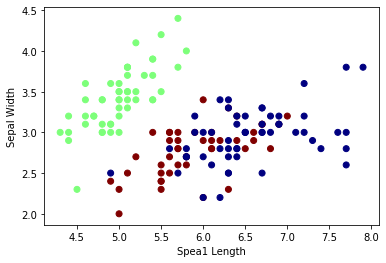

In [6]:
plt.scatter(X[:,0], X[:,1], c=labels, cmap='jet')
plt.xlabel('Spea1 Length')
plt.ylabel('Sepal Width')
plt.show()

### Built-in function

In [7]:
score=adjusted_rand_score(y,labels2)
print("Adjusted Rand Score:",score)

Adjusted Rand Score: 0.9038742317748124


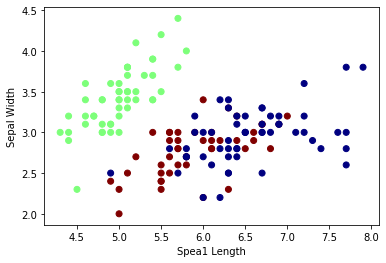

In [8]:
plt.scatter(X[:,0], X[:,1], c=labels2, cmap='jet')
plt.xlabel('Spea1 Length')
plt.ylabel('Sepal Width')
plt.show()